## Install Libraries ##


In [35]:
!pip install geopandas fiona pyproj shapely rtree pingouin scipy seaborn libpysal gdown mapclassify pysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
## Load Libraries ##
import pandas as pd
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.explore import esda  # Exploratory Spatial analytics
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from splot.esda import plot_local_autocorrelation
from splot.esda import plot_moran
from libpysal.examples import load_example, available
from scipy import stats
from pingouin import ttest
import pingouin as pg
from libpysal.weights.contiguity import Rook
import splot
from sklearn.preprocessing import robust_scale
from scipy.stats import levene
from pysal.model import spreg
from libpysal.weights import Queen, Rook, KNN
import statsmodels.formula.api as smf

## Load Data ##

In [37]:
airbnb = gpd.read_file('/content/drive/MyDrive/Airbnb/airbnb_Chicago 2015.shp')
airbnb = airbnb.fillna(0)

airbnb_2022_summary = gpd.read_file('/content/drive/MyDrive/Airbnb/listings.csv')
print(airbnb)

          community     shape_area      shape_len  AREAID  response_r  \
0           DOUGLAS  46004621.1581  31027.0545098      35   98.771429   
1           OAKLAND  16913961.0408  19565.5061533      36   99.200000   
2       FULLER PARK  19916704.8692              0      37   68.000000   
3   GRAND BOULEVARD  48492503.1554  28196.8371573      38   94.037037   
4           KENWOOD  29071741.9283  23325.1679062      39   92.542857   
..              ...            ...            ...     ...         ...   
72  MOUNT GREENWOOD  75584290.0209  48665.1305392      74    0.000000   
73      MORGAN PARK  91877340.6988   46396.419362      75   85.500000   
74            OHARE  371835607.687   173625.98466      76   83.500000   
75        EDGEWATER  48449990.8397  31004.8309456      77   94.429530   
76      EDISON PARK  31636313.7864   25937.226841       9  100.000000   

      accept_r  rev_rating    price_pp  room_type  num_spots  ...  crowded  \
0    94.514286   87.777778   78.157895   1.78

## Visual Exploration

## 1. Two Plots

Text(0.5, 0, 'number of airbnbs')

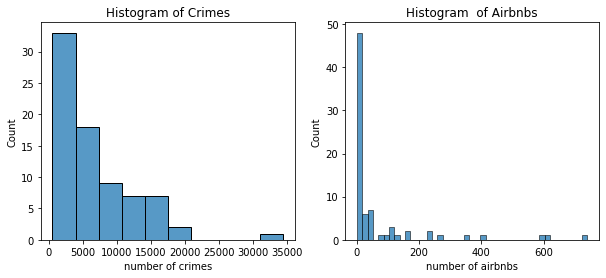

In [38]:
fig, ax = plt.subplots(1,2, figsize =(10,4));

sns.histplot(data = airbnb, x='num_crimes', ax=ax[0]);
ax[0].set_title('Histogram of Crimes');
ax[0].set_xlabel('number of crimes')

sns.histplot(data = airbnb, x='num_spots', ax=ax[1]);
ax[1].set_title('Histogram  of Airbnbs');
ax[1].set_xlabel('number of airbnbs')

#airbnb.crime = airbnb['num_crimes']
#airbnb.crime.plot(kind='hist')
#ax.set_xlabel('number of crimes')
#ax.set_title('Frequency of Crimes in Chicago')

Both plots are right skewed.

## 3. Correlation Coefficient

In [39]:
# find out how to do this

airbnb.select_dtypes(include=['int']).dtypes

AREAID        int64
num_spots     int64
income_pc     int64
harship_in    int64
num_crimes    int64
num_theft     int64
population    int64
dtype: object

In [40]:
airbnb_numeric = airbnb.select_dtypes(include=['int'])

corr_df = pg.pcorr(airbnb_numeric)
corr_df

,AREAID,num_spots,income_pc,harship_in,num_crimes,num_theft,population
AREAID,1.000000,-0.089573,-0.249740,-0.109116,-0.001069,0.147701,-0.261928
num_spots,-0.089573,1.000000,0.118812,0.066280,-0.441813,0.532394,0.455653
income_pc,-0.249740,0.118812,1.000000,-0.774424,-0.194821,0.464938,-0.187961
harship_in,-0.109116,0.066280,-0.774424,1.000000,0.164637,0.135552,-0.246410
num_crimes,-0.001069,-0.441813,-0.194821,0.164637,1.000000,0.778140,0.510345
num_theft,0.147701,0.532394,0.464938,0.135552,0.778140,1.000000,-0.153417
population,-0.261928,0.455653,-0.187961,-0.246410,0.510345,-0.153417,1.000000


In [41]:
corr_df1 = pg.pcorr(airbnb)
corr_df1

,AREAID,response_r,accept_r,rev_rating,price_pp,room_type,num_spots,poverty,crowded,dependency,without_hs,unemployed,income_pc,harship_in,num_crimes,num_theft,population
AREAID,1.000000,-0.015821,0.088940,-0.195916,-0.085569,0.196102,0.018398,-0.197427,-0.107232,-0.034931,0.068529,0.138927,-0.167550,0.007780,0.035195,0.127536,-0.247837
response_r,-0.015821,1.000000,0.595785,0.795790,0.328616,0.255489,0.097866,-0.149914,-0.066429,0.167417,0.051898,0.092445,-0.071475,-0.012965,0.046035,-0.060331,-0.029490
accept_r,0.088940,0.595785,1.000000,-0.204510,-0.097332,0.008092,-0.052900,0.046550,0.072070,-0.201681,-0.036671,-0.133570,-0.016954,0.014473,0.135490,-0.075543,-0.058488
rev_rating,-0.195916,0.795790,-0.204510,1.000000,-0.229920,0.060676,-0.015967,0.175903,0.099756,-0.070473,0.083796,0.063739,0.075124,-0.127163,-0.014141,0.043350,-0.067201
price_pp,-0.085569,0.328616,-0.097332,-0.229920,1.000000,-0.000196,-0.030076,0.112106,0.092418,-0.088173,-0.169833,-0.127367,0.170483,0.073046,-0.080452,0.198064,-0.008678
room_type,0.196102,0.255489,0.008092,0.060676,-0.000196,1.000000,-0.197179,-0.054684,-0.129286,-0.199158,-0.121033,-0.071389,0.038352,0.211485,-0.125177,0.030962,0.227301
num_spots,0.018398,0.097866,-0.052900,-0.015967,-0.030076,-0.197179,1.000000,0.187695,-0.144399,-0.148700,-0.049301,-0.041956,0.068099,0.047077,-0.466178,0.483443,0.534482
poverty,-0.197427,-0.149914,0.046550,0.175903,0.112106,-0.054684,0.187695,1.000000,-0.138592,-0.469837,-0.503162,-0.036217,-0.029805,0.716481,-0.002287,-0.023470,-0.124358
crowded,-0.107232,-0.066429,0.072070,0.099756,0.092418,-0.129286,-0.144399,-0.138592,1.000000,-0.145720,0.242789,-0.346667,0.003206,0.305299,-0.053597,0.049826,0.178326
dependency,-0.034931,0.167417,-0.201681,-0.070473,-0.088173,-0.199158,-0.148700,-0.469837,-0.145720,1.000000,-0.358800,-0.026197,-0.048210,0.512217,0.026196,-0.138601,-0.049467


In [42]:
corr_df[['num_crimes']]

,num_crimes
AREAID,-0.001069
num_spots,-0.441813
income_pc,-0.194821
harship_in,0.164637
num_crimes,1.000000
num_theft,0.778140
population,0.510345


In [43]:
corr_df[['num_spots']]

,num_spots
AREAID,-0.089573
num_spots,1.000000
income_pc,0.118812
harship_in,0.066280
num_crimes,-0.441813
num_theft,0.532394
population,0.455653


Text(0.5, 1.0, 'Pairwise Correlation')

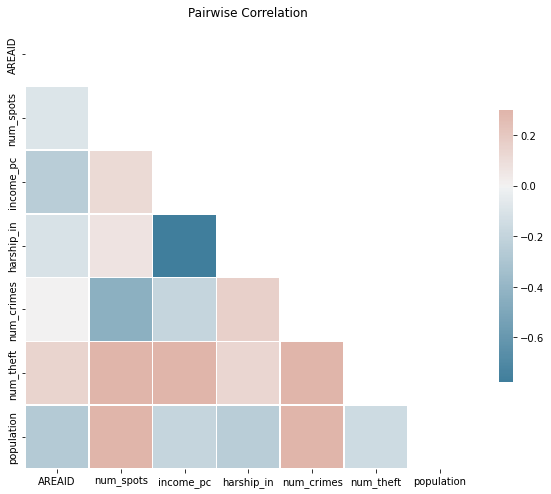

In [44]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Pairwise Correlation')

Absence of linear relationships between numeric variables in the data.

## 2. Summary Table ##
# this can be the table that is used for plot. aggregate statistic (mean, sum, etc.)

In [45]:
print('Mean Crimes by Community')
airbnb.groupby('community')['num_crimes'].mean()

Mean Crimes by Community


community
ALBANY PARK        4896.0
ARCHER HEIGHTS     1902.0
ARMOUR SQUARE      2104.0
ASHBURN            4894.0
AUBURN GRESHAM    15334.0
                   ...   
WEST LAWN          4214.0
WEST PULLMAN       7977.0
WEST RIDGE         6271.0
WEST TOWN         14705.0
WOODLAWN           7585.0
Name: num_crimes, Length: 77, dtype: float64

In [46]:
print('Top 5 Highest Mean Crimes by Community')
crime = airbnb.groupby('community')['num_crimes'].mean()
crime.nlargest(5)

Top 5 Highest Mean Crimes by Community


community
AUSTIN             34365.0
NEAR NORTH SIDE    18947.0
SOUTH SHORE        17466.0
NORTH LAWNDALE     16980.0
NEAR WEST SIDE     16873.0
Name: num_crimes, dtype: float64

In [47]:
print('Number of Airbnbs in Highest Crime Communities' )
spots = airbnb.groupby('community')['num_spots'].mean()
spots[['AUSTIN', 'NEAR NORTH SIDE', 'SOUTH SHORE', 'NORTH LAWNDALE', 'NEAR WEST SIDE']]

Number of Airbnbs in Highest Crime Communities


community
AUSTIN              10.0
NEAR NORTH SIDE    593.0
SOUTH SHORE         21.0
NORTH LAWNDALE      11.0
NEAR WEST SIDE     262.0
Name: num_spots, dtype: float64

## Statistical Tests

## 4. One Sample t/z-test

In [48]:
print('The average of num_crimes variable is:', round(airbnb['num_crimes'].mean(), 3))

The average of num_crimes variable is: 6870.078


In [69]:

print('One Sample T-test for Crimes')
stats.ttest_1samp(airbnb['num_crimes'], popmean=6870)


One Sample T-test for Crimes


Ttest_1sampResult(statistic=0.00011630149267928876, pvalue=0.9999075095717802)

* $H_0$: $\mu \leq 6870$ AND $H_a$: $\mu > 6870$ (one-tailed test) 
* $\alpha=0.05$

In [50]:
print(stats.ttest_1samp(airbnb.num_crimes.dropna(), popmean=6870, alternative='greater'))
print('Our p-value is not below **alpha**, thus we cannot reject the null hypothesis.')
print('We are 95% confident, that the population mean number of crimes is less than 6870')

Ttest_1sampResult(statistic=0.00011630149267928876, pvalue=0.4999537547858901)
Our p-value is not below **alpha**, thus we cannot reject the null hypothesis.
We are 95% confident, that the population mean number of crimes is less than 6870


## 5. Two Sample Test

* $H_0$: $\mu = 6870$ AND $H_a$: $\mu \neq 6870$ (two-tailed test)
* $\alpha=0.05$

In [51]:
print(stats.ttest_1samp(airbnb.num_crimes.dropna(), popmean=6870))
print('Our p-value is not below alpha, thus we cannot reject the null hypothesis.')
print(f'We are 95% confident, that the population number of crimes is indeed 6870.')

Ttest_1sampResult(statistic=0.00011630149267928876, pvalue=0.9999075095717802)
Our p-value is not below alpha, thus we cannot reject the null hypothesis.
We are 95% confident, that the population number of crimes is indeed 6870.


I think that the mean number of crimes will be about equal for the North and South parts of Chicago.

In [52]:
y_mean = airbnb.geometry.centroid.y.mean()

north = airbnb.loc[airbnb.geometry.centroid.y>=y_mean]
south = airbnb[~airbnb.community.isin(north.community)]

print(north.shape)
print(south.shape)

(35, 21)
(42, 21)


Text(0.5, 1.0, 'North vs South')

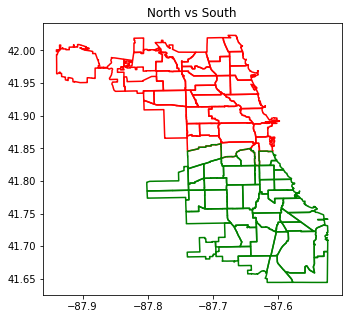

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

north.boundary.plot(ax=ax, color='red', aspect=1)
south.boundary.plot(ax=ax, color='green', aspect=1)
ax.set_title('North vs South')

In [54]:
ttest(north.num_crimes, south.num_crimes)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.491811,57.187982,two-sided,0.141245,"[-705.51, 4828.75]",0.353855,0.617,0.332519


In [55]:
stat, p = levene(north.num_crimes, south.num_crimes)

print('Stat value is:', stat)
print('\nP-value is:', p)

Stat value is: 1.8260494330171182

P-value is: 0.18065704037130498


The p-value is not very low signifying that the mean number of crimes is not equal between the two regions of Chicago.

## 6. ANOVA Test

* $H_0$: $\mu_1 = \mu_2 = ... = \mu_k$ for $k$ neighborhoods
* $H_a$: at least one of the means is different 

How does the number of crimes between residents without high school vary? 

In [56]:
aov = pg.anova(dv='num_crimes', between='without_hs', data=airbnb,
               detailed=True)
print('Following is ANOVA test report')
aov

Following is ANOVA test report


,Source,SS,DF,MS,F,p-unc,np2
0,without_hs,2.547622e+09,68,3.746502e+07,3.777363,0.024874,0.969795
1,Within,7.934641e+07,8,9.918301e+06,NaN,NaN,NaN


#### With p-value of 0.969795 there is not enough statistical evidence to reject the null. At least one of the neighborhoods mean is different at $\alpha=0.05$ confidence interval. 

## 7. Global Moran's *I*

* $H_0$: The mean number of crimes of Airbnb ads is spatially random
* $H_a$: The mean number of crimes of Airbnb ads is NOT spatial random (i.e. spatially correlated) 

In [57]:
y = airbnb['num_crimes'].values
w = Rook.from_dataframe(airbnb)

print('Weights before normalizing:', w[0])
w.transform = 'r'
print('Weights after normalizing:', w[0])

Weights before normalizing: {1: 1.0, 34: 1.0, 3: 1.0, 33: 1.0}
Weights after normalizing: {1: 0.25, 34: 0.25, 3: 0.25, 33: 0.25}


In [58]:
moran = Moran(y, w)
print('\nMoran I-value:', moran.I)
print("Moran's p-val:", moran.p_sim)


Moran I-value: 0.3892135344524518
Moran's p-val: 0.001


#### We observe positive spatial autocorrelation. Moran's $I$ is 0.39. With simulated p-value < 0.001, we have enough statistical evidence to reject the null. 

## Visual Exploration Part II

## 8. Moran Scatter Plot

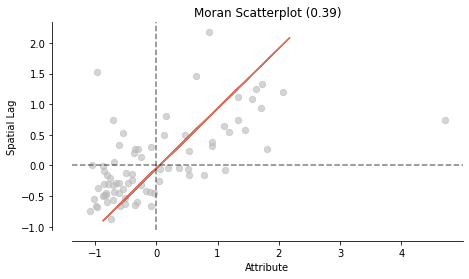

In [59]:
#belongs in Visual Exploration
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

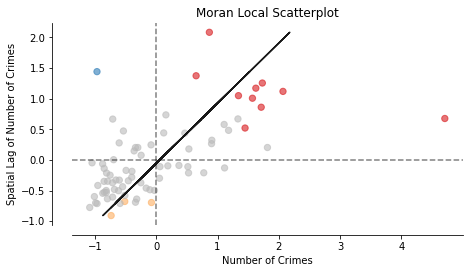

In [97]:
# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Number of Crimes')
ax.set_ylabel('Spatial Lag of Number of Crimes')
plt.show()



```
# This is formatted as code
```

# Geographical Analysis

## 9. Choropleth Map


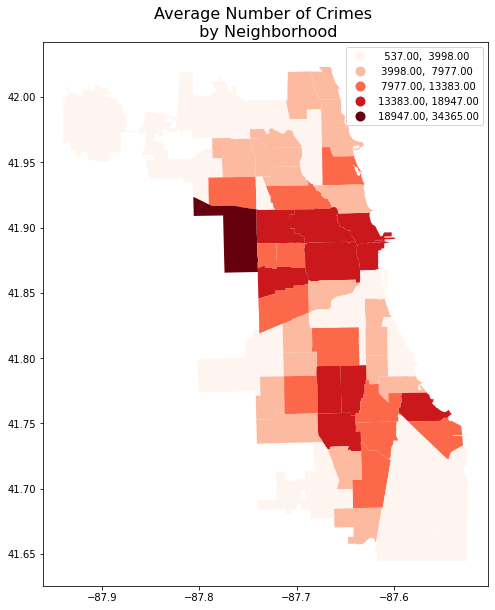

In [61]:
fig, ax = plt.subplots(figsize=(10,10))

airbnb.plot(column='num_crimes', legend=True, scheme='FisherJenks', cmap='Reds', ax=ax);

ax.set_title('Average Number of Crimes \n by Neighborhood', fontsize=16);

Text(0.5, 42.0, 'Latitudes')

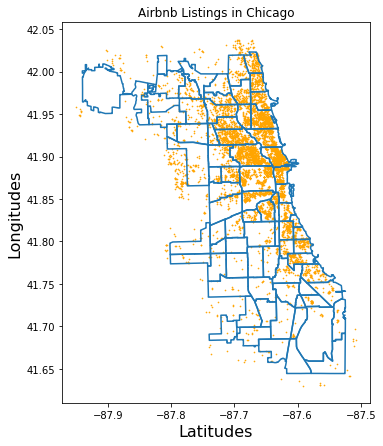

In [62]:
airbnb_gdf = gpd.GeoDataFrame(
    airbnb_2022_summary, geometry=gpd.points_from_xy(airbnb_2022_summary.longitude, airbnb_2022_summary.latitude),
    crs="EPSG:3857")

fig, ax = plt.subplots(figsize=(10, 7))
airbnb_gdf.plot(ax=ax, fc = 'orange', markersize=0.4)
airbnb.boundary.plot(ax=ax)
ax.set_title('Airbnb Listings in Chicago')
ax.set_ylabel('Longitudes', fontsize=16)
ax.set_xlabel('Latitudes', fontsize=16)

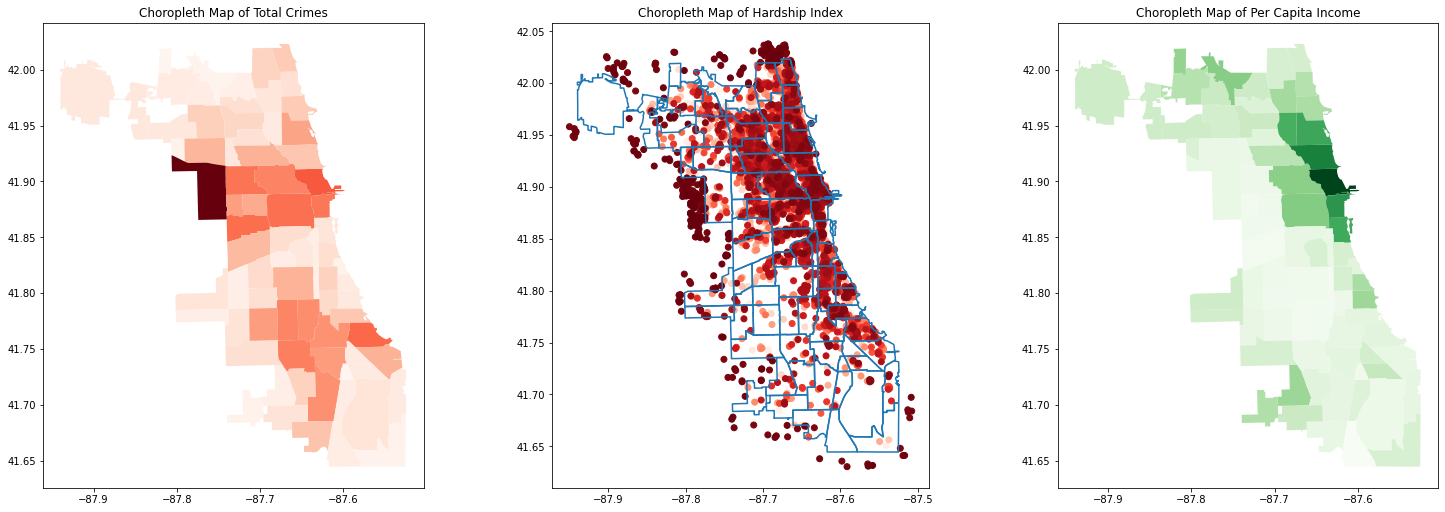

In [63]:
from matplotlib.colorbar import constrained_layout

fig, ax = plt.subplots(1,3, figsize=(21,7), constrained_layout=True)

airbnb.plot(column='num_crimes', cmap='Reds', ax=ax[0]);
ax[0].set_title('Choropleth Map of Total Crimes');

airbnb_gdf.plot( cmap='Reds', ax=ax[1]);
airbnb.boundary.plot(ax=ax[1]);
ax[1].set_title('Choropleth Map of Hardship Index');

airbnb.plot(column='income_pc', cmap='Greens', ax=ax[2]);
ax[2].set_title('Choropleth Map of Per Capita Income');

#airbnb.plot(column='harship_in', legend=True, scheme='FisherJenks', cmap='Reds', ax=ax);

#ax.set_title('Average Hardship Index \n by Neighborhood', fontsize=16);

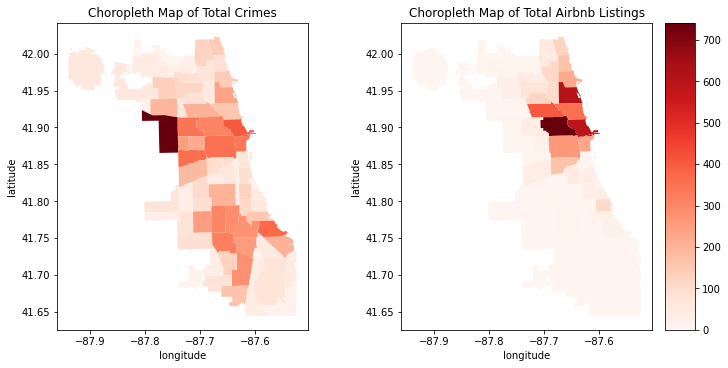

In [64]:
from matplotlib.colorbar import constrained_layout

fig, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

airbnb.plot(column='num_crimes', cmap='Reds', ax=ax[0]);
ax[0].set_title('Choropleth Map of Total Crimes');
ax[0].set_xlabel('longitude');
ax[0].set_ylabel('latitude');

airbnb.plot(column='num_spots', cmap='Reds', ax=ax[1], legend=True);
ax[1].set_title('Choropleth Map of Total Airbnb Listings');
ax[1].set_xlabel('longitude');
ax[1].set_ylabel('latitude');

#airbnb.plot(column='income_pc', cmap='Greens', ax=ax[2]);
#ax[2].set_title('Choropleth Map of Per Capita Income');

#airbnb.plot(column='harship_in', legend=True, scheme='FisherJenks', cmap='Reds', ax=ax);

#ax.set_title('Average Hardship Index \n by Neighborhood', fontsize=16);

## Lisa Plot

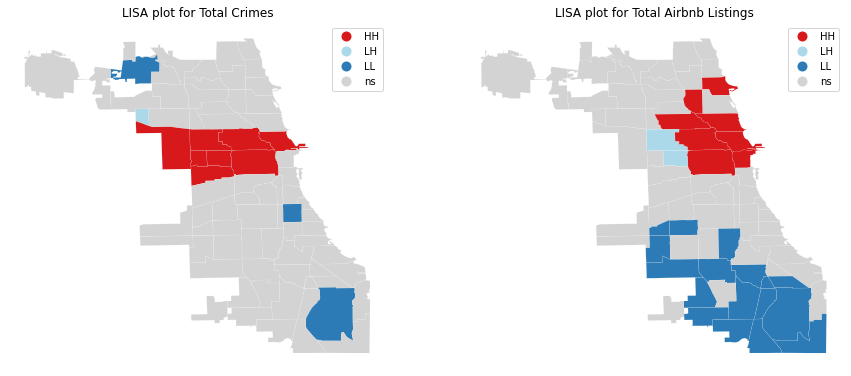

In [65]:
##################
# YOUR CODE HERE #
# modify below   #
##################
# Row-standardization
w.transform = "R"

# set your modeled variable to be 'y'
y1 = airbnb['num_crimes']
y2 = airbnb['num_spots']
#y3 = airbnb['income_pc']

# calculate Moran_Local and plot
moran_loc1 = Moran_Local(y1, w)
moran_loc2 = Moran_Local(y2, w)
#moran_loc3 = Moran_Local(y3, w)

fig, ax = plt.subplots(1,2, figsize = (15, 15))

lisa_cluster(moran_loc1, airbnb, p=0.05, ax=ax[0]);
ax[0].set_title('LISA plot for Total Crimes')

lisa_cluster(moran_loc2, airbnb, p=0.05, ax=ax[1])
ax[1].set_title('LISA plot for Total Airbnb Listings')

#lisa_cluster(moran_loc3, airbnb, p=0.05, ax=ax[2])
#ax[2].set_title('LISA plot for Per Capita Income')
plt.show()

## 10. Clustering Partition

In [66]:
predictors = ['rev_rating', 'price_pp', 'num_spots', 'without_hs', 'unemployed',
              'income_pc', 'harship_in', 'population']

In [67]:
db_scaled = robust_scale(airbnb[predictors])

Text(0.5, 1.0, 'Hierarchical Clustering Map of Chicago')

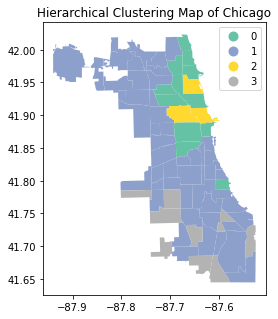

In [81]:
from sklearn.cluster import AgglomerativeClustering

# Set seed for reproducibility
np.random.seed(0)

# Iniciate the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=4)

# Run clustering
model.fit(db_scaled)

# Assign labels to main data table
airbnb["ward5"] = model.labels_


# Setup figure and ax
f, axs = plt.subplots(figsize=(4, 6))

# Plot unique values choropleth including
# a legend and with no boundary lines
airbnb.plot(
    column="ward5",
    categorical=True,
    cmap="Set2",
    legend=True,
    linewidth=0,
    ax=axs
)
axs.set_title('Hierarchical Clustering Map of Chicago')

Regression

Kitchen Sink

In [77]:
mod2 = pg.linear_regression(airbnb[['rev_rating', 'price_pp', 'num_spots', 'without_hs', 'unemployed',
              'income_pc', 'harship_in', 'population']], airbnb['num_crimes'])
mod2.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-8790.97,2930.69,-3.00,0.00,0.71,0.67,-14639.08,-2942.86
1,rev_rating,5.69,14.09,0.40,0.69,0.71,0.67,-22.43,33.81
2,price_pp,16.65,13.72,1.21,0.23,0.71,0.67,-10.73,44.03
3,num_spots,-4.75,4.46,-1.06,0.29,0.71,0.67,-13.65,4.15
4,without_hs,-299.62,92.83,-3.23,0.00,0.71,0.67,-484.87,-114.38
5,unemployed,107.24,134.62,0.80,0.43,0.71,0.67,-161.39,375.88
6,income_pc,0.09,0.06,1.48,0.14,0.71,0.67,-0.03,0.21
7,harship_in,179.77,60.00,3.00,0.00,0.71,0.67,60.05,299.49
8,population,0.22,0.02,9.39,0.00,0.71,0.67,0.17,0.26


OLS

In [96]:
# Fitting linear model
res = smf.ols(formula= 'num_crimes ~ rev_rating + price_pp + num_spots + without_hs + unemployed + income_pc + harship_in + population', data=airbnb).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             num_crimes   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     20.36
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           2.51e-15
Time:                        00:34:35   Log-Likelihood:                -729.98
No. Observations:                  77   AIC:                             1478.
Df Residuals:                      68   BIC:                             1499.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8790.9713   2930.693     -3.000      0.004   -1.46e+04   -2942.865
rev_rating     5.6873     14.093      0.404      0.688     -22.434      33.809
price_pp      16.6479     13.722      1.213      0.229     -10.734      44.030
num_spots     -4.7499      4.462     -1.065      0.291     -13.653       4.154
without_hs  -299.6248     92.832     -3.228      0.002    -484.868    -114.382
unemployed   107.2415    134.622      0.797      0.428    -161.393     375.876
income_pc      0.0915      0.062      1.484      0.142      -0.032       0.215
harship_in   179.7734     59.995      2.996      0.004      60.054     299.492
population     0.2176      0.023      9.385      0.000       0.171       0.264
==============================================================================
Omnibus:                        6.097   Durbin-Watson:                   1.365
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.962
Skew:                           0.445   Prob(JB):                       0.0507
Kurtosis:                       4.032   Cond. No.                     3.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Spatial Model

In [89]:
w_knn = KNN.from_dataframe(airbnb, k=15)
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
# Dependent variable
airbnb[["num_crimes"]].values,
# Independent variables
airbnb[['rev_rating', 'price_pp', 'num_spots', 'without_hs', 'unemployed',
              'income_pc', 'harship_in', 'population']].values,
# Spatial weights matrix
w=w_knn,
# Dependent variable name
name_y="log_price",
# Independent variables names
name_x=predictors,
)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:          77
Mean dependent var  :   6870.0779                Number of Variables   :           9
S.D. dependent var  :   5879.2320                Degrees of Freedom    :          68
Pseudo R-squared    :      0.7028
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -8242.1130918    2809.0032238      -2.9341772       0.0033443
          rev_rating       9.4013225      11.2068292       0.8388923       0.4